In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                    # probelmatic dimension 3
                                     #"wa-sa-B3",  
                                     #"wa-sa-A2", 
                                     #"wa-sa-B2", 
                                     "wa-sa-A3",
                                     "wa-sa-A1", 
                                     "wa-sa-B1", 
                                     
                                     "wa-sa-D2",
                                     "wa-sa-D1",
                                     #"wa-sa-C2",

                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-A4",

                                     "wa-sa-A5", 
                                     "wa-sa-C3", # Pos
                                     "wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 1.2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.2,
                                     eps=0.4,
                                     outlier_quantile=0.0001,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_wa)

Finished compute clusters in 1.102184534072876 seconds
Finished compute transformed features in 0.3370358943939209 seconds
Finished predict cluster labels in 0.2856485843658447 seconds
Finished predict labels in 0.09029984474182129 seconds


all_data: array([580649.61363481, 567201.03343863, 519810.41037185, 775454.94531809, 629424.8984976 , 626092.23288712])
zero_cluster: array([4552.02708072, 4057.98121764, 3611.95697644, 4519.02878668, 1311.93240028, 3594.29422528]

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 9.528176604753369e-05, n_outlier: 16

Total error rate: 0.004972068079776158
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.006444     0.004986   0.009955   0.003141   0.002722 0.002585

Precision (TP / (TP + FP)): 0.9411078614063201
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99971          1.0   0.477126   0.998112   0.997355      1.0

Recall / TPR (TP / (TP + FN)): 0.9981670968123434
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999515       0.9978   0.988109   0.998065        1.0 0.997483

Specificity / TNR (TN / (TN + FP)): 0.9995377405832306
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999996          1.0   0.997263   0.999994   0.999975      1.0

Accuracy ((TP + TN) / (P + N)): 0.9995276717233075
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99999     0.999977    0.99724   0.999988   0.999975 0.999984

F1 (2 * (precision * 

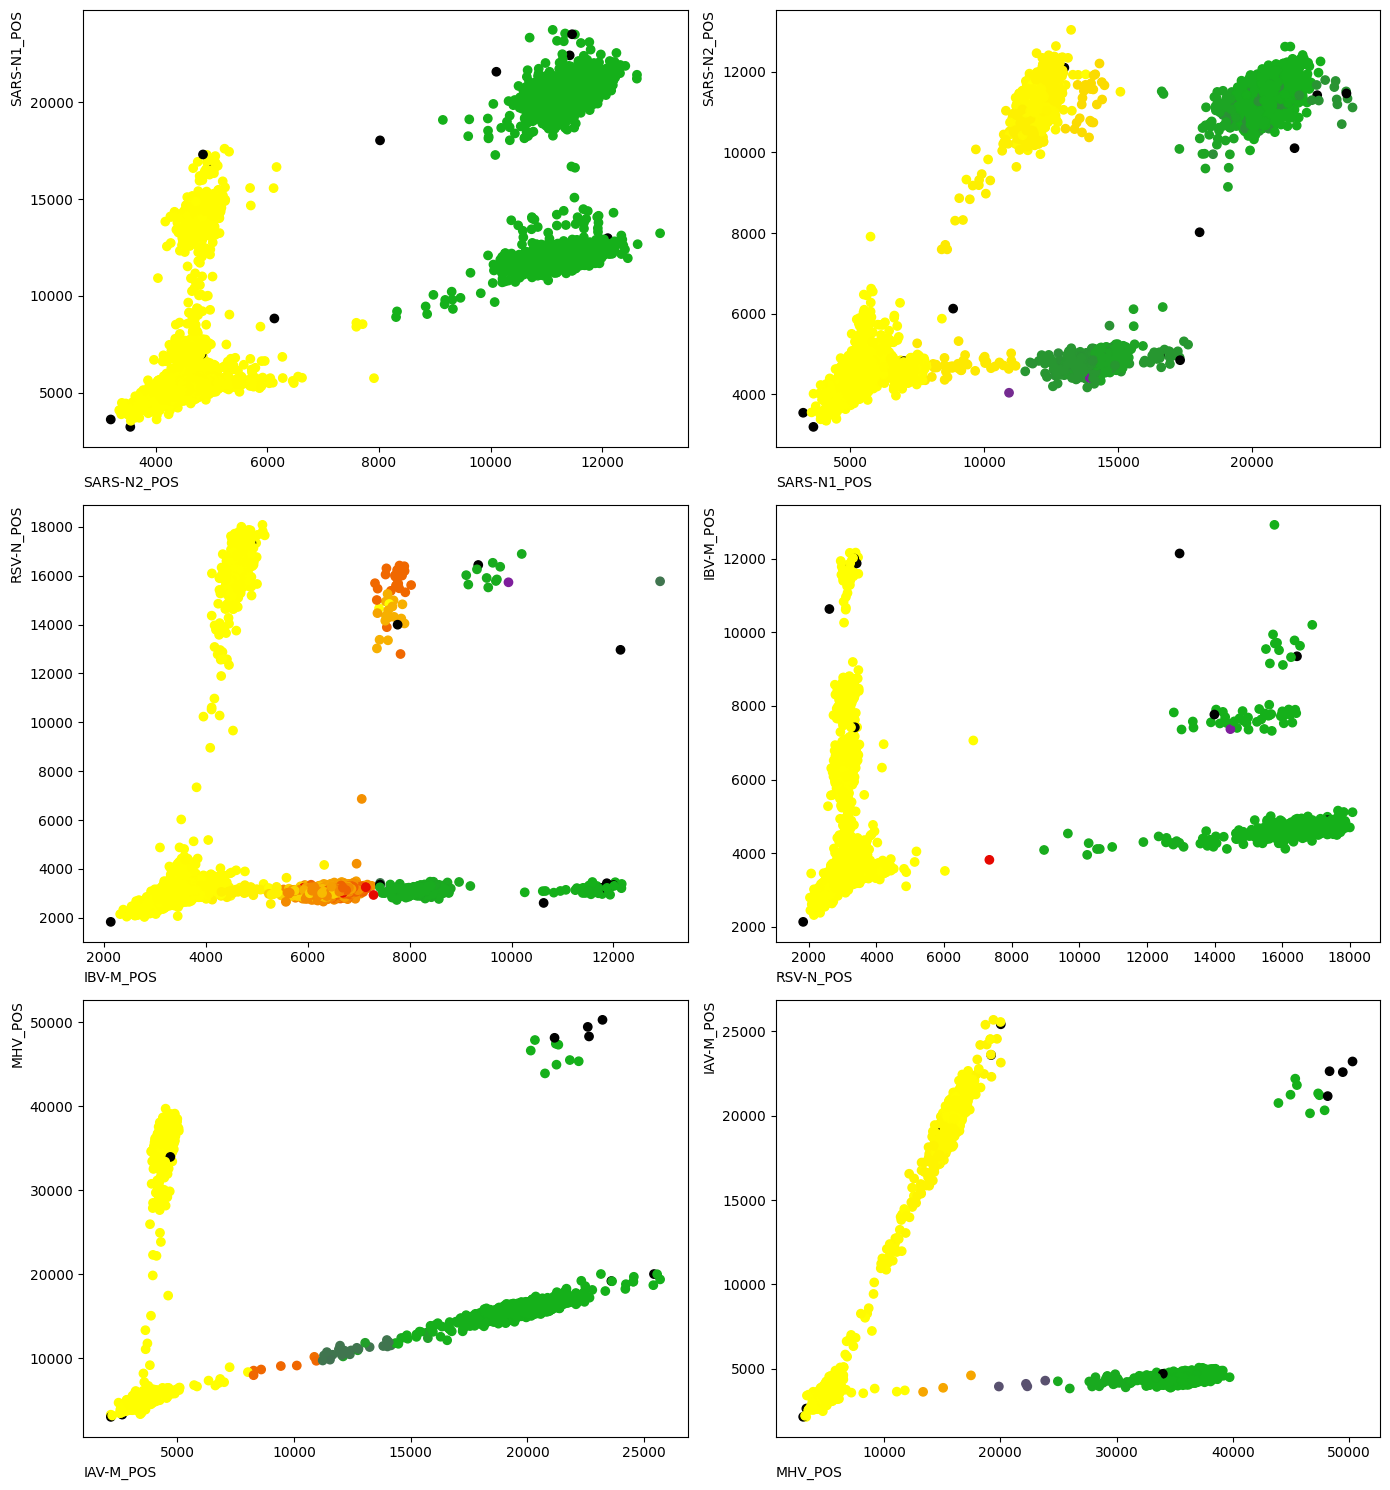

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, threshold=0.5)

df_result = stats_lib.compute_results(df_predictions, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )